In [92]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
!pip freeze
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

absl-py==0.9.0
adal==1.2.2
affine==2.3.0
aiohttp==3.6.2
alabaster==0.7.12
albumentations==0.4.5
alembic==1.4.2
allennlp==0.9.0
altair==4.1.0
anaconda-client==1.7.2
anaconda-project==0.8.3
annoy==1.16.3
ansiwrap==0.8.4
appdirs==1.4.3
argh==0.26.2
arrow==0.15.5
arviz==0.7.0
asn1crypto==1.3.0
astor==0.8.1
astroid==2.3.3
astropy==4.0.1.post1
async-generator==1.10
async-timeout==3.0.1
atomicwrites==1.3.0
attrs==19.3.0
audioread==2.1.8
autopep8==1.5.1
Babel==2.8.0
backcall==0.1.0
backports.shutil-get-terminal-size==1.0.0
Baker==1.3
basemap==1.2.1
bayesian-optimization @ git+https://github.com/fmfn/BayesianOptimization.git@235de0ddc5873d0e1487e7d0841a8d1a5a0b2f64
bayespy==0.5.19
bcolz==1.2.1
beautifulsoup4==4.9.0
binaryornot==0.4.4
biopython==1.76
bitarray==1.2.1
bkcharts==0.2
black==19.10b0
bleach==3.1.4
blinker==1.4
blis==0.4.1
bokeh==2.0.1
Boruta==0.3
boto==2.49.0
boto3==1.13.7
botocore==1.16.7
Bottleneck==1.3.2
-e git+https://github.com/SohierDane/BigQuery_Helper@8615a7f6c1663e7f2d48aa2b3

/kaggle/input/cleanerdata/betterdata.csv
/kaggle/input/dddddd/depressionset.csv
/kaggle/input/googlenewsvectorsnegative300/GoogleNews-vectors-negative300.bin
/kaggle/input/testing/normal1.csv
/kaggle/input/twoandhalfmen/tahm.csv


In [71]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from gensim.models import KeyedVectors
import nltk
from nltk.corpus import stopwords
import re
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import *
import string
import re
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import gensim
import logging
from numpy import random
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix
import joblib

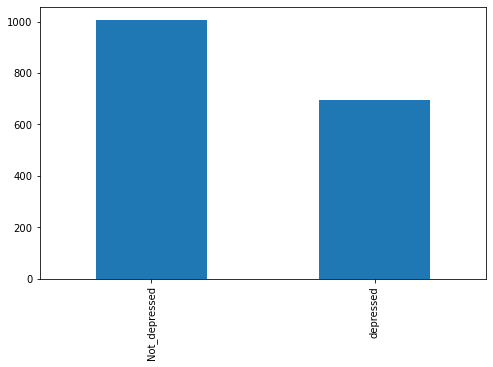

In [30]:
#importing train data
train_data = pd.read_csv('/kaggle/input/cleanerdata/betterdata.csv')
#checking out the distribution of classes using a simple histogram
plt.figure(figsize=(8, 5))
train_data.Label.value_counts().plot(kind='bar');

first things first, we need to consider the imbalance

In [31]:
train_data.head()

,Unnamed: 0,text,Label
0,0,Is that the real ? 3 : 00,Not_depressed
1,1,I don ’ t get how anyone this man funny,Not_depressed
2,2,My actor when I was growing up this guy was am...,Not_depressed
3,3,the family seeing him come out of the rhino wa...,Not_depressed
4,4,0 : 51 why would they put that in a movie !,Not_depressed


In [32]:
#train_data = train_data.drop(columns=['Unnamed: 0'])
#confirming there are no missing values
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1702 entries, 0 to 1701
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  1702 non-null   int64 
 1   text        1679 non-null   object
 2   Label       1702 non-null   object
dtypes: int64(1), object(2)
memory usage: 40.0+ KB


In [33]:
null_columns = train_data[train_data['text'].isnull()]

In [34]:
null_columns

,Unnamed: 0,text,Label
35,35,NaN,Not_depressed
36,36,NaN,Not_depressed
46,46,NaN,Not_depressed
50,50,NaN,Not_depressed
195,195,NaN,Not_depressed
228,228,NaN,Not_depressed
231,231,NaN,Not_depressed
312,312,NaN,Not_depressed
403,403,NaN,Not_depressed
424,424,NaN,Not_depressed


In [35]:
#the missing values originated from previous preprocessing when non-english texts were removed
#best approach is to drop them
train_data = train_data.dropna()
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1679 entries, 0 to 1701
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  1679 non-null   int64 
 1   text        1679 non-null   object
 2   Label       1679 non-null   object
dtypes: int64(1), object(2)
memory usage: 52.5+ KB


In [63]:
#PERFORMING DATA CLEANING
space_replace = re.compile('[/(){}\[\]\|@,;]')
bad_symbols = re.compile('[^0-9a-z #+_]')
stopwords = nltk.corpus.stopwords.words('english')
extensions = ['rt', 'RT']
stopwords.extend(extensions)
urls = re.compile('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|'
            '[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+' 'rt')

def text_cleaning(text):
    text = BeautifulSoup(text, "lxml").text #removing any html decoding
    text = text.lower() #removing capitalization
    text = space_replace.sub(' ', text)#replacing symbols with a space
    text = bad_symbols.sub('', text) #deleting symbols from the text
    text = ' '.join(word for word in text.split() if word not in stopwords) #removing stopwords
    text = urls.sub('', text)#removing urls
    return text
train_data['cleaned_text'] = train_data['text'].apply(text_cleaning)
train_data.head()

AttributeError: 'WordListCorpusReader' object has no attribute 'append'

In [41]:
#CREATING THE WORD2VEC MODEL
word_vectors = gensim.models.KeyedVectors.load_word2vec_format('/kaggle/input/googlenewsvectorsnegative300/GoogleNews-vectors-negative300.bin', binary=True)
word_vectors.init_sims(replace=True)

**BASIC FEATURE ENGINEERING**

In [42]:
#word averaging
def word_averaging(wv, words):
    all_words, mean = set(), []
    
    for word in words:
        if isinstance(word, np.ndarray):
            mean.append(word)
        elif word in wv.vocab:
            mean.append(wv.syn0norm[wv.vocab[word].index])
            all_words.add(wv.vocab[word].index)

    if not mean:
        logging.warning("cannot compute similarity with no input %s", words)
        
        return np.zeros(wv.vector_size,)

    mean = gensim.matutils.unitvec(np.array(mean).mean(axis=0)).astype(np.float32)
    return mean

def  word_averaging_list(wv, text_list):
    return np.vstack([word_averaging(wv, post) for post in text_list ])


In [43]:
def w2v_tokenize_text(text):
    tokens = []
    for sent in nltk.sent_tokenize(text, language='english'):
        for word in nltk.word_tokenize(sent, language='english'):
            if len(word) < 2:
                continue
            tokens.append(word)
    return tokens

In [45]:
train_data['cleaned_text'] = train_data['cleaned_text'].astype(str)

**APPLYING THE FEATURE ENGINEERING FUNCTIONS TO OUT FEATURE COLUMN(PREPROCESSED TEXT)**

In [48]:
train, test = train_test_split(train_data, test_size = 0.3, random_state = 42)
test_tokenized = test.apply(lambda r: w2v_tokenize_text(r['cleaned_text']), axis=1).values
train_tokenized = train.apply(lambda r: w2v_tokenize_text(r['cleaned_text']), axis=1).values

In [51]:
X_train_word_average = word_averaging_list(word_vectors, train_tokenized)
X_test_word_averaging = word_averaging_list(word_vectors, test_tokenized)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `syn0norm` (Attribute will be removed in 4.0.0, use self.vectors_norm instead).
  if __name__ == '__main__':


**FITTING THE MODELS**

In [52]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(penalty = 'l2', C=0.1)#the penalty function reduces overfitting
lr = lr.fit(X_train_word_average, train['Label'])
preds = lr.predict(X_test_word_averaging)

In [53]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
print('accuracy %s' % accuracy_score(preds, test.Label))
print(classification_report(test.Label, preds))

accuracy 0.875
               precision    recall  f1-score   support

Not_depressed       0.84      0.96      0.90       281
    depressed       0.94      0.77      0.84       223

     accuracy                           0.88       504
    macro avg       0.89      0.86      0.87       504
 weighted avg       0.88      0.88      0.87       504



**TRYING OUT XGB CLASSIFIER**

In [57]:
from xgboost import XGBClassifier

model2 = XGBClassifier(
    max_depth=2,
    gamma=2,
    eta=0.8,
    reg_alpha=0.5,
    reg_lambda=0.5
)
model2.fit(X_train_word_average, train['Label'])
xgb_predictions = model2.predict(X_test_word_averaging)

In [58]:
print('accuracy %s' % accuracy_score(xgb_predictions, test.Label))
print(classification_report(test.Label, xgb_predictions))

accuracy 0.8928571428571429
               precision    recall  f1-score   support

Not_depressed       0.90      0.91      0.90       281
    depressed       0.89      0.87      0.88       223

     accuracy                           0.89       504
    macro avg       0.89      0.89      0.89       504
 weighted avg       0.89      0.89      0.89       504



**CROSS VALIDATION FOR XGB CLASSIFIER**

In [65]:
#PERFORMING CROSS VALIDATION
y = train_data['Label']
X = train_data.apply(lambda r: w2v_tokenize_text(r['cleaned_text']), axis=1).values
X = word_averaging_list(word_vectors, X)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `syn0norm` (Attribute will be removed in 4.0.0, use self.vectors_norm instead).
  if __name__ == '__main__':


In [66]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(model2, X, y, cv=5)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.90 (+/- 0.02)


**CROSS VALIDATION FOR LOGISTIC REGRESSION CLASSIFIER**

In [68]:
from sklearn.model_selection import cross_val_score
scores1 = cross_val_score(lr,X,y, cv=5 )
print("Accuracy: %0.2f (+/- %0.2f)" % (scores1.mean(), scores1.std() * 2))

Accuracy: 0.88 (+/- 0.02)


**XGB CLASSIFIER HAS A HIGHER CROSS VAL SCORE, HIGHER RECALL AND HIGHER OVERALL ACCURACY. THIS MODEL WILL THEREFORE BE USED FOR CLASSIFICATION PURPOSES
**

In [72]:
modelname = 'xgbmodel.sav'
joblib.dump(model2, modelname)

['xgbmodel.sav']

In [85]:
test_data = pd.read_csv('/kaggle/input/twoandhalfmen/tahm.csv')
test_data.columns

Index(['ID', 'Author Name', 'Author Channel URL', 'Public', 'Published',
       'Comment', 'Likes', 'Comment URL'],
      dtype='object')

In [86]:
test_data = test_data.drop(columns=['ID', 'Author Name', 'Author Channel URL', 'Public', 'Published','Likes', 'Comment URL'])
test_data = test_data.rename(columns={'Comment':'Text'})
test_data.head()

,Text
0,impossible mission
1,sit near a window LMFAO
2,GET UP!!! LOL
3,1:08
4,Nice how Jake said hey!


In [87]:
#PERFORMING DATA CLEANING
space_replace = re.compile('[/(){}\[\]\|@,;]')
bad_symbols = re.compile('[^0-9a-z #+_]')
stoplist = nltk.corpus.stopwords.words('english')
extensions = ['rt', 'RT']
stoplist.extend(extensions)
urls = re.compile('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|'
            '[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+' 'rt')

def test_text_cleaning(text):
    text = BeautifulSoup(text, "lxml").text #removing any html decoding
    text = text.lower() #removing capitalization
    text = space_replace.sub(' ', text)#replacing symbols with a space
    text = bad_symbols.sub('', text) #deleting symbols from the text
    text = ' '.join(word for word in text.split() if word not in stoplist) #removing stopwords
    text = urls.sub('', text)#removing urls
    return text


In [88]:
test_data['cleaned_text'] = test_data['Text'].apply(test_text_cleaning)
test_data.head()

,Text,cleaned_text
0,impossible mission,impossible mission
1,sit near a window LMFAO,sit near window lmfao
2,GET UP!!! LOL,get lol
3,1:08,108
4,Nice how Jake said hey!,nice jake said hey


In [89]:
test_data['cleaned_text'] = test_data['cleaned_text'].astype(str)
test_data_tokenized = test_data.apply(lambda r: w2v_tokenize_text(r['cleaned_text']), axis=1).values
test_data_word_averaging = word_averaging_list(word_vectors, test_data_tokenized)



/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `syn0norm` (Attribute will be removed in 4.0.0, use self.vectors_norm instead).
  if __name__ == '__main__':


**LOADING THE XGB MODEL THAT WE HAD SAVED AND USING IT TO PREDICT THE TEST DATA**

In [90]:
loaded_xgb = joblib.load(modelname)
predictions = loaded_xgb.predict(test_data_word_averaging)
test_data['predictionsmade'] = predictions
test_data.head()

,Text,cleaned_text,predictionsmade
0,impossible mission,impossible mission,Not_depressed
1,sit near a window LMFAO,sit near window lmfao,depressed
2,GET UP!!! LOL,get lol,Not_depressed
3,1:08,108,Not_depressed
4,Nice how Jake said hey!,nice jake said hey,Not_depressed


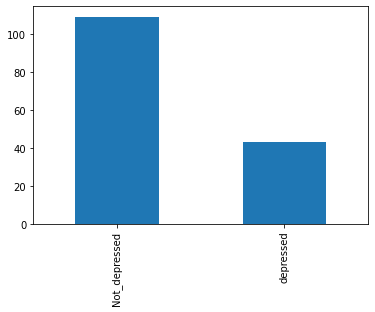

In [91]:
#visualizations of the result
test_data.predictionsmade.value_counts().plot(kind='bar');

In [93]:
test_data2 = pd.read_csv('/kaggle/input/dddddd/depressionset.csv')
test_data2.columns

Index(['ID', 'Author Name', 'Author Channel URL', 'Public', 'Published',
       'Comment', 'Likes', 'Comment URL'],
      dtype='object')

In [94]:
test_data2 = test_data2.drop(columns=['ID', 'Author Name', 'Author Channel URL', 'Public', 'Published','Likes', 'Comment URL'])
test_data2 = test_data2.rename(columns={'Comment':'Text'})
test_data2['cleaned_text'] = test_data2['Text'].apply(test_text_cleaning)
test_data2.head()

/opt/conda/lib/python3.7/site-packages/bs4/__init__.py:398: UserWarning: "https://youtu.be/DP3NZIeASkA" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  markup


,Text,cleaned_text
0,thx,thx
1,I feel like crying alot,feel like crying alot
2,Go to a mw2 lobby and ask for advice,go mw2 lobby ask advice
3,I still wana die,still wana die
4,I randomly start crying like even when nothing...,randomly start crying like even nothing wrong ...


In [95]:
test_data2['cleaned_text'] = test_data2['cleaned_text'].astype(str)
test_data2_tokenized = test_data2.apply(lambda r: w2v_tokenize_text(r['cleaned_text']), axis=1).values
test_data2_word_averaging = word_averaging_list(word_vectors, test_data2_tokenized)
predictions2 = loaded_xgb.predict(test_data2_word_averaging)
test_data2['predictionsmade'] = predictions2
test_data2.head()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `syn0norm` (Attribute will be removed in 4.0.0, use self.vectors_norm instead).
  if __name__ == '__main__':


,Text,cleaned_text,predictionsmade
0,thx,thx,Not_depressed
1,I feel like crying alot,feel like crying alot,depressed
2,Go to a mw2 lobby and ask for advice,go mw2 lobby ask advice,depressed
3,I still wana die,still wana die,depressed
4,I randomly start crying like even when nothing...,randomly start crying like even nothing wrong ...,Not_depressed


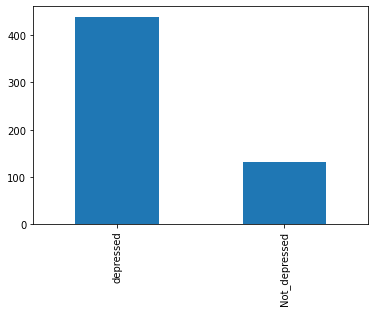

In [96]:
#visualizations of the result
test_data2.predictionsmade.value_counts().plot(kind='bar');

NOTES:
The cleaning function was repeated twice because a stopwords complication occured when applying the previous function to the test set. 
The model seems to be performing as expected. 
The first test set was obtained from a comment section of a youtube commedy video commentary section and as seen, the number of depressed tweets was signigicantly low. 
THe second test was obtained from a youtube video on depression where I assumed most depressed people would be posting their comments. As expected, the number of depressed comments were higher than those that were not depressed. 
While these results may be pleasing, it is important to factor in that the approach used still has its own shortcomings. 
